<a href="https://colab.research.google.com/github/Kashish-28/Underwater-image-enhancement/blob/main/Copy_of_INTERN_FINAL_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow matplotlib scikit-image

In [ ]:
!pip install sewar

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, UpSampling2D, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from sewar.full_ref import vifp
import zipfile
import os


In [ ]:
# Check if the file exists
file_path = '/content/dataset zip.zip'
if os.path.exists(file_path):
    print("File exists, proceeding to unzip.")
else:
    print("File does not exist. Please upload the zip file with the correct name and path.")

# Try unzipping the file
try:
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall('/content/dataset')
    print("Unzipping successful.")
except zipfile.BadZipFile:
    print("Error: File is not a zip file or it is corrupted.")


File exists, proceeding to unzip.
Unzipping successful.


In [ ]:
# Define the Generator
def build_generator():
    def conv2d(layer_input, filters, f_size=4, bn=True):
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input])
        return u

    d0 = Input(shape=(256, 256, 3))

    # Downsampling
    d1 = conv2d(d0, 64, bn=False)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)
    d5 = conv2d(d4, 512)
    d6 = conv2d(d5, 512)
    d7 = conv2d(d6, 512)

    # Upsampling
    u1 = deconv2d(d7, d6, 512)
    u2 = deconv2d(u1, d5, 512)
    u3 = deconv2d(u2, d4, 512)
    u4 = deconv2d(u3, d3, 256)
    u5 = deconv2d(u4, d2, 128)
    u6 = deconv2d(u5, d1, 64)

    u7 = UpSampling2D(size=2)(u6)
    output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

    return Model(d0, output_img)

In [ ]:
# Define the Discriminator
def build_discriminator():
    def d_layer(layer_input, filters, f_size=4, bn=True):
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    img_A = Input(shape=(256, 256, 3))
    img_B = Input(shape=(256, 256, 3))
    combined_imgs = Concatenate(axis=-1)([img_A, img_B])

    d1 = d_layer(combined_imgs, 64, bn=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d2, 256)
    d4 = d_layer(d3, 512)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([img_A, img_B], validity)

In [ ]:
# Define the Refinement Network
def build_refinement_network():
    def conv2d(layer_input, filters, f_size=4, bn=True):
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, filters, f_size=4):
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        u = BatchNormalization(momentum=0.8)(u)
        return u

    img_input = Input(shape=(256, 256, 3))

    # Downsampling
    d1 = conv2d(img_input, 64, bn=False)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)

    # Upsampling
    u1 = deconv2d(d4, 512)
    u2 = deconv2d(u1, 256)
    u3 = deconv2d(u2, 128)
    u4 = deconv2d(u3, 64)

    output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

    return Model(img_input, output_img)


In [ ]:
# Loss functions
def build_gan(generator, discriminator):
    img_A = Input(shape=(256, 256, 3))
    img_B = Input(shape=(256, 256, 3))
    fake_B = generator(img_A)

    discriminator.trainable = False
    validity = discriminator([img_A, fake_B])

    return Model([img_A, img_B], [validity, fake_B])


In [ ]:
# Load and preprocess the dataset
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

def preprocess_image(image):
    image = tf.image.resize(image, [256, 256])
    image = (image - 0.5) * 2
    return image

def load_and_preprocess_image(path):
    image = load_image(path)
    image = preprocess_image(image)
    return image

def load_dataset(trainA_path, trainB_path):
    trainA_files = sorted([os.path.join(trainA_path, file) for file in os.listdir(trainA_path)])
    trainB_files = sorted([os.path.join(trainB_path, file) for file in os.listdir(trainB_path)])
    dataset_A = tf.data.Dataset.from_tensor_slices(trainA_files)
    dataset_B = tf.data.Dataset.from_tensor_slices(trainB_files)
    dataset_A = dataset_A.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset_B = dataset_B.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = tf.data.Dataset.zip((dataset_A, dataset_B))
    return dataset.batch(1)

In [ ]:
# Hyperparameters
epochs = 200
batch_size = 1

# Paths to the dataset folders
trainA_path = '/content/dataset/trainA'  # Update the path accordingly
trainB_path = '/content/dataset/trainB'  # Update the path accordingly

# Load the dataset
train_dataset = load_dataset(trainA_path="/content/dataset/dataset2/trainA", trainB_path="/content/dataset/dataset2/trainB")

# Build and compile the models
generator = build_generator()
discriminator = build_discriminator()
refinement_network = build_refinement_network()

discriminator.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5), metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5))


In [ ]:
# Training parameters
epochs = 50
batch_size = 1

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for step, (img_A, img_B) in enumerate(train_dataset):
        # Train the discriminator
        fake_B = generator(img_A)
        d_loss_real = discriminator.train_on_batch([img_A, img_B], np.ones((batch_size, 16, 16, 1)))
        d_loss_fake = discriminator.train_on_batch([img_A, fake_B], np.zeros((batch_size, 16, 16, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        g_loss = gan.train_on_batch([img_A, img_B], [np.ones((batch_size, 16, 16, 1)), img_B])

        if step % 10 == 0:
            print(f'Step: {step}, D loss: {d_loss}, G loss: {g_loss}')

# Save the generator model
generator.save('/content/generator_final.keras')

# Load the saved generator model
generator = tf.keras.models.load_model('/content/generator_final.keras')


Epoch 1/50
Step: 0, D loss: [3.24116611 0.44921875], G loss: [70.69515228271484, 0.885651171207428, 0.6980950236320496]
Step: 10, D loss: [1.28166044 0.48632812], G loss: [41.45435333251953, 2.8689541816711426, 0.38585400581359863]
Epoch 2/50
Step: 0, D loss: [1.22069001 0.51171875], G loss: [34.85540008544922, 1.2316418886184692, 0.3362375497817993]
Step: 10, D loss: [0.77622029 0.5       ], G loss: [28.844924926757812, 1.5377120971679688, 0.27307212352752686]
Epoch 3/50
Step: 0, D loss: [0.67391953 0.49804688], G loss: [26.200868606567383, 0.9706355333328247, 0.2523023188114166]
Step: 10, D loss: [0.53350305 0.52929688], G loss: [23.222490310668945, 0.8740949034690857, 0.22348396480083466]
Epoch 4/50
Step: 0, D loss: [0.48832035 0.49414062], G loss: [22.284942626953125, 0.49965769052505493, 0.21785284578800201]
Step: 10, D loss: [0.40609749 0.50585938], G loss: [19.30933952331543, 0.6642469763755798, 0.18645092844963074]
Epoch 5/50
Step: 0, D loss: [0.39366955 0.484375  ], G loss: [2

In [ ]:
# Function to preprocess and enhance an image using the generator
def enhance_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = preprocess_image(image)
    image = tf.expand_dims(image, axis=0)
    enhanced_image = generator.predict(image)
    enhanced_image = (enhanced_image + 1) / 2.0
    enhanced_image = np.squeeze(enhanced_image)
    return enhanced_image


In [ ]:
# Function to calculate and print image metrics
def calculate_metrics(original_image, enhanced_image):
    ssim_value = ssim(original_image, enhanced_image, channel_axis=-1)
    psnr_value = psnr(original_image, enhanced_image)
    mse_value = mse(original_image, enhanced_image)
    vifp_value = vifp(original_image, enhanced_image)
    return ssim_value, psnr_value, mse_value, vifp_value


In [ ]:
# Function to plot images
def plot_images(original_image_path, enhanced_image):
    original_image = load_image(original_image_path)
    original_image = preprocess_image(original_image)
    original_image = (original_image + 1) / 2  # Scale to [0, 1]
    original_image = original_image.numpy()

    enhanced_image = np.clip(enhanced_image, 0, 1)  # Clip values to [0, 1]
    enhanced_image = np.array(enhanced_image)  # Ensure it's a NumPy array

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Enhanced Image')
    plt.imshow(enhanced_image)
    plt.axis('off')
    plt.show()

In [ ]:
# Function to evaluate metrics for a batch of images
def evaluate_batch_metrics(image_paths):
    ssim_values, psnr_values, mse_values, vifp_values = [], [], [], []

    for path in image_paths:
        original_image = load_image(path)
        original_image = preprocess_image(original_image)
        original_image = (original_image + 1) / 2  # Scale to [0, 1]
        original_image = original_image.numpy()

        enhanced_image = enhance_image(path)
        ssim_value, psnr_value, mse_value, vifp_value = calculate_metrics(original_image, enhanced_image)
        ssim_values.append(ssim_value)
        psnr_values.append(psnr_value)
        mse_values.append(mse_value)
        vifp_values.append(vifp_value)

    avg_ssim = np.mean(ssim_values)
    avg_psnr = np.mean(psnr_values)
    avg_mse = np.mean(mse_values)
    avg_vifp = np.mean(vifp_values)

    print(f"Average SSIM: {avg_ssim}")
    print(f"Average PSNR: {avg_psnr}")
    print(f"Average MSE: {avg_mse}")
    print(f"Average VIFP: {avg_vifp}")

In [ ]:

# Example usage
sample_image_paths = [os.path.join('/content/dataset/dataset2/trainA', file) for file in os.listdir('/content/dataset/dataset2/trainA')[:10]]  # Sample a few images
evaluate_batch_metrics(sample_image_paths)

1/1 [==============================] - 0s 20ms/step
Average SSIM: 0.8763128519058228
Average PSNR: 20.72137561491719
Average MSE: 0.008858783209512163
Average VIFP: 1.0617180949033735


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Function to plot histograms of pixel intensities
def plot_histograms(original_image_path, enhanced_image):
    original_image = tf.io.read_file(original_image_path)
    original_image = tf.image.decode_jpeg(original_image)
    original_image = tf.image.convert_image_dtype(original_image, tf.float32)
    original_image = preprocess_image(original_image)
    original_image = (original_image + 1) / 2  # Scale to [0, 1]
    original_image = original_image.numpy()

    enhanced_image = np.clip(enhanced_image, 0, 1)  # Clip values to [0, 1]
    enhanced_image = np.array(enhanced_image)  # Ensure it's a NumPy array

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Original Image Histogram')
    plt.hist(original_image.ravel(), bins=256, color='blue', alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Enhanced Image Histogram')
    plt.hist(enhanced_image.ravel(), bins=256, color='green', alpha=0.5)

    plt.show()

1/1 [==============================] - 0s 21ms/step


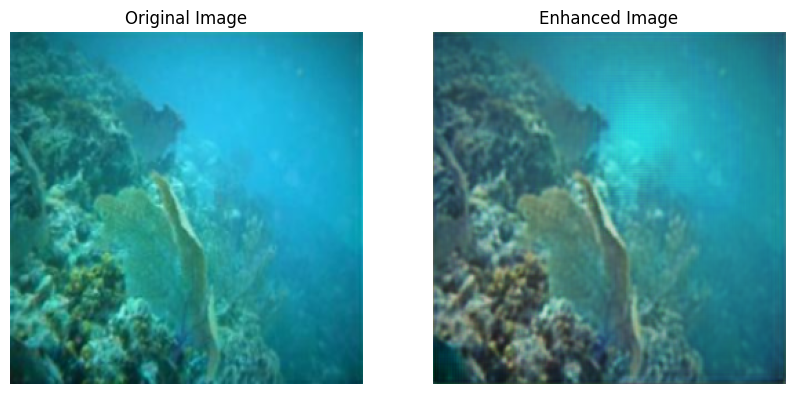

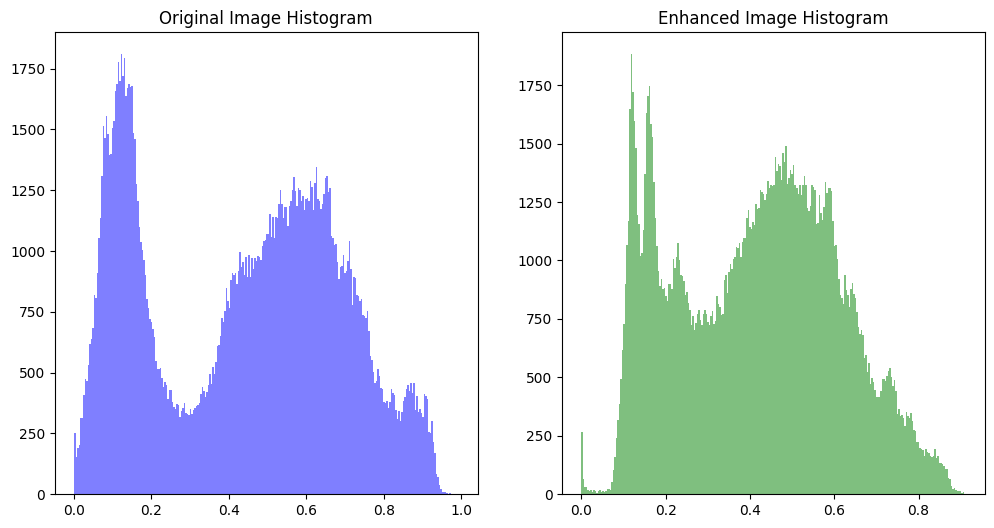

1/1 [==============================] - 0s 21ms/step


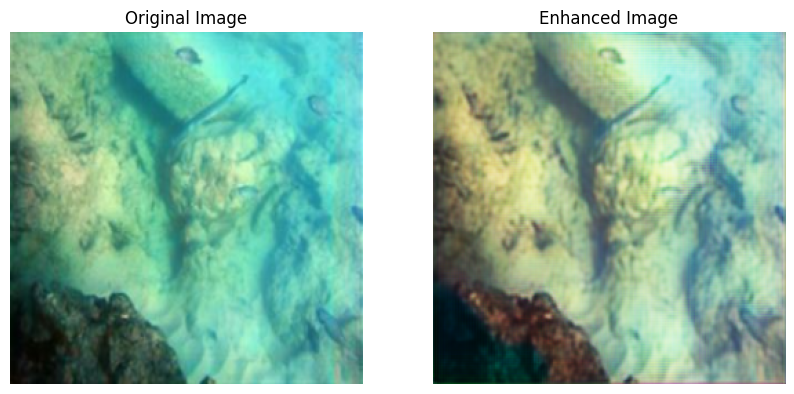

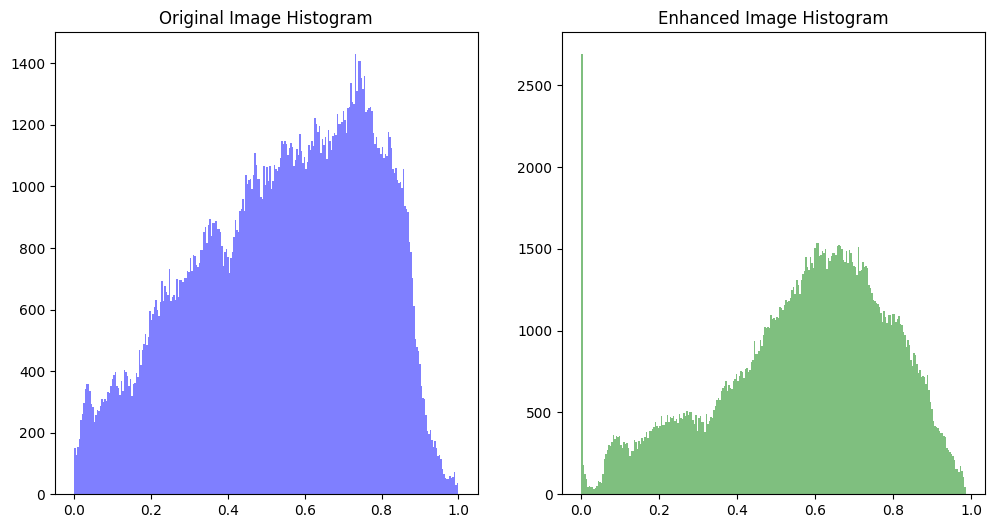

1/1 [==============================] - 0s 20ms/step


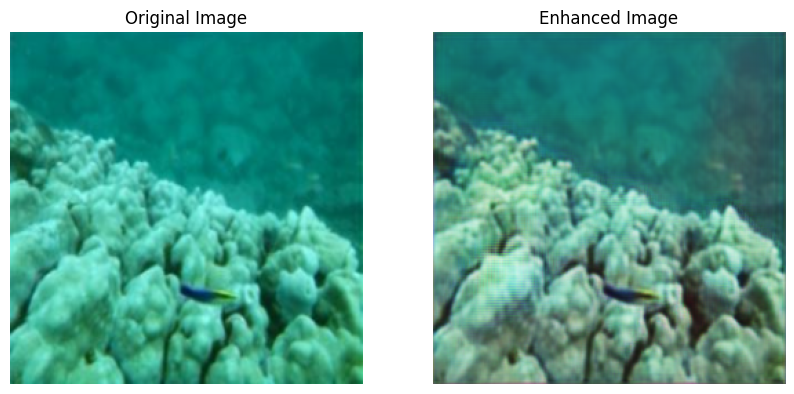

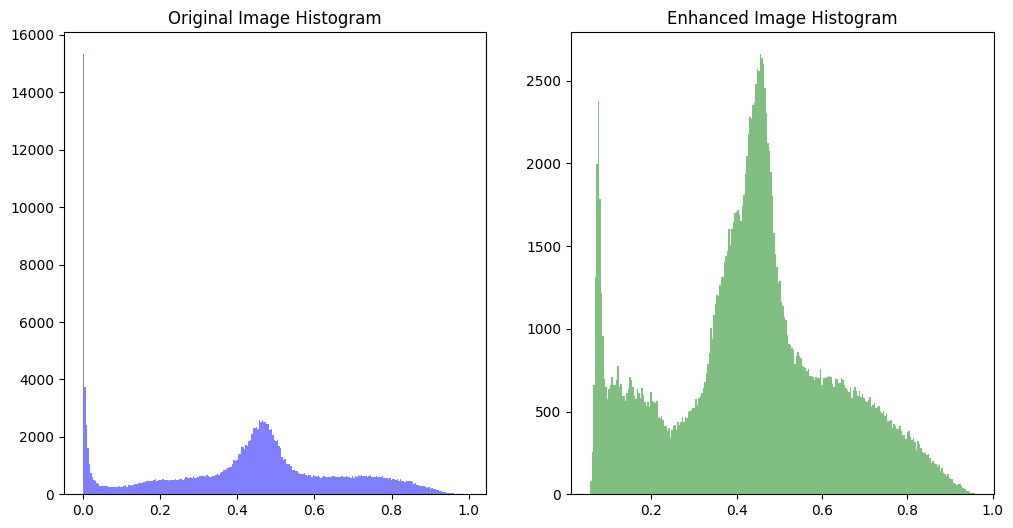

1/1 [==============================] - 0s 21ms/step


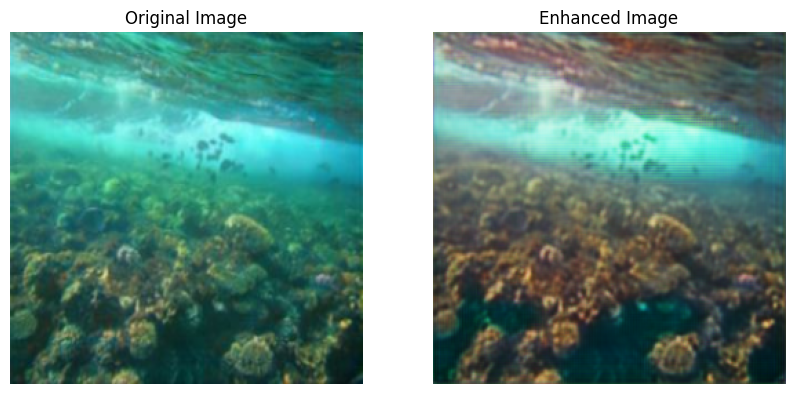

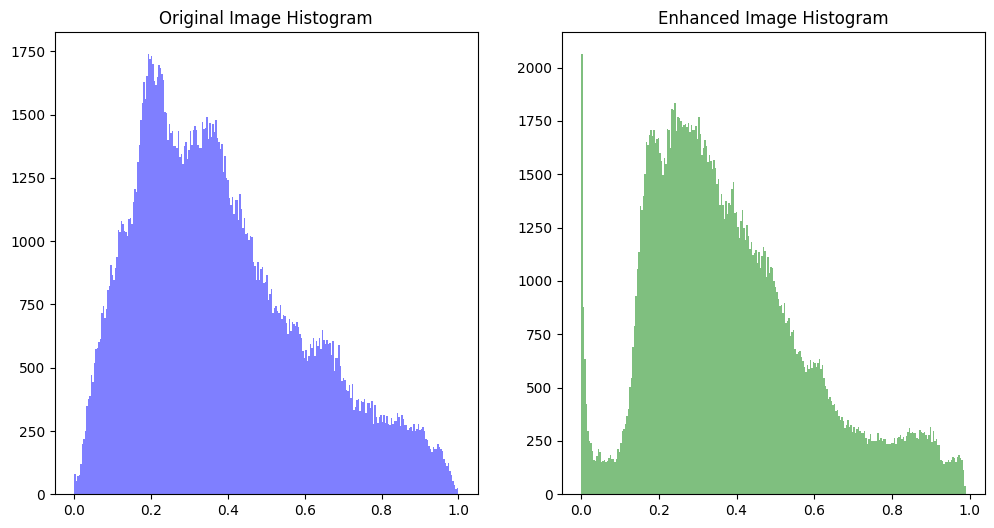

1/1 [==============================] - 0s 27ms/step


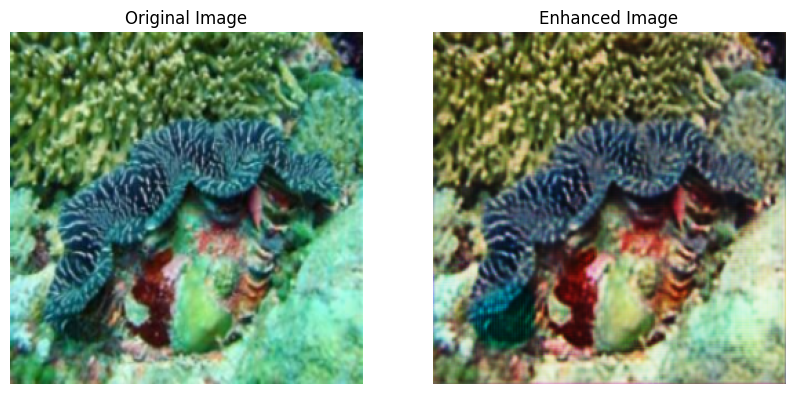

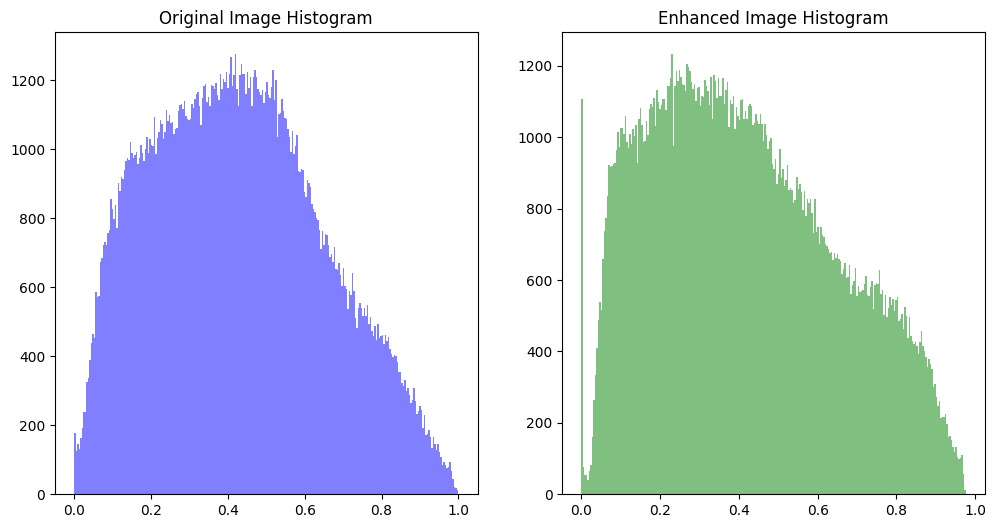

1/1 [==============================] - 0s 19ms/step


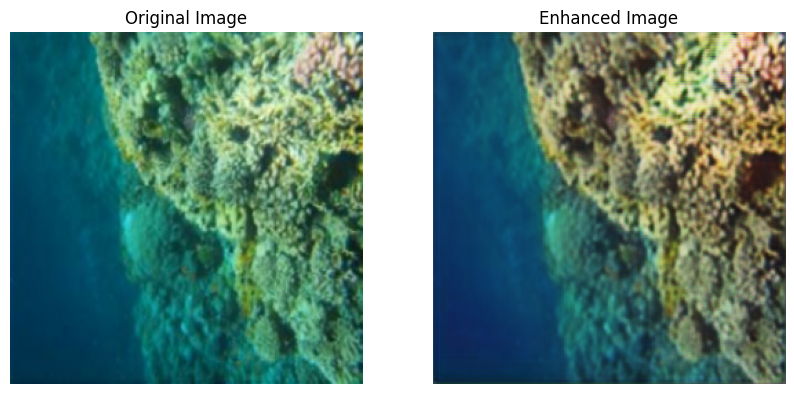

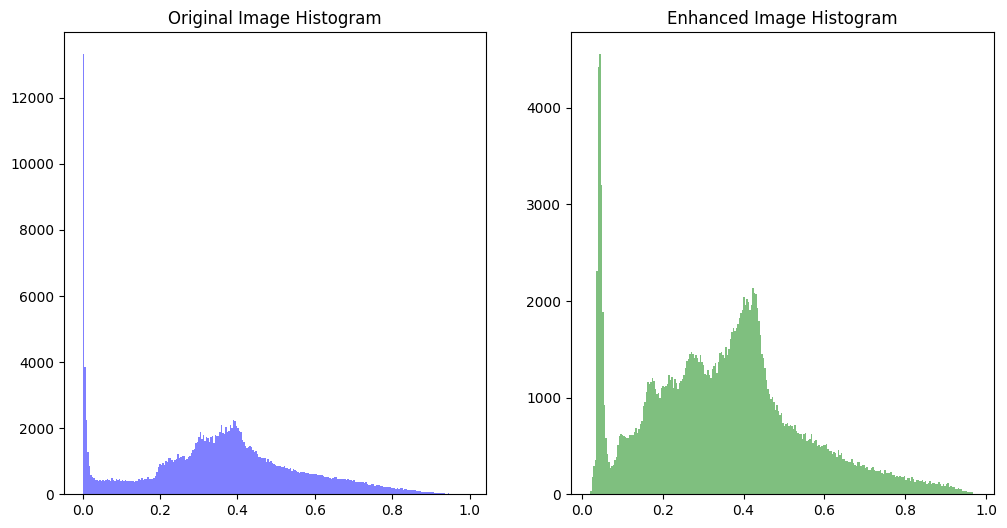

1/1 [==============================] - 0s 39ms/step


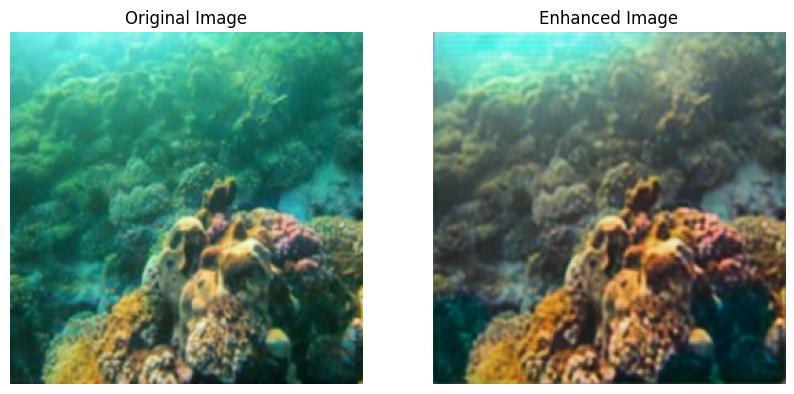

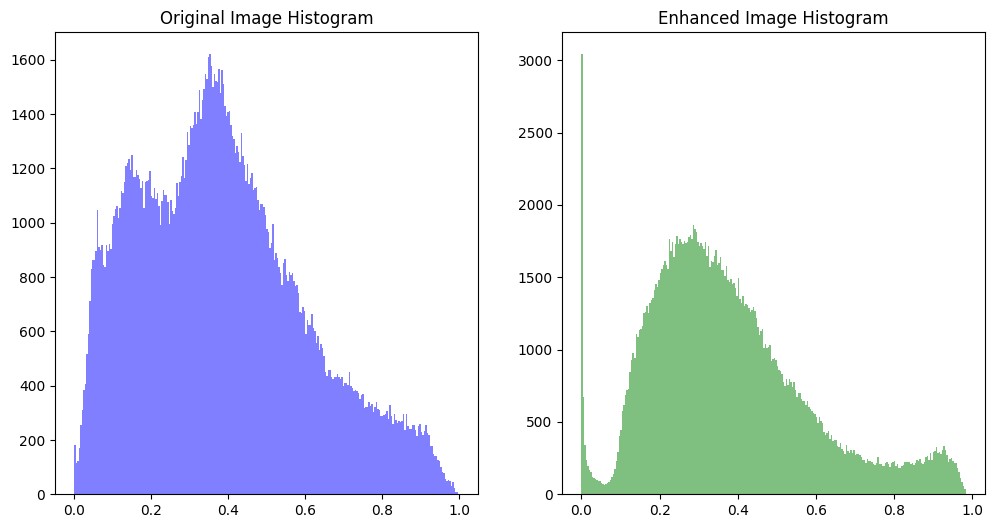

1/1 [==============================] - 0s 20ms/step


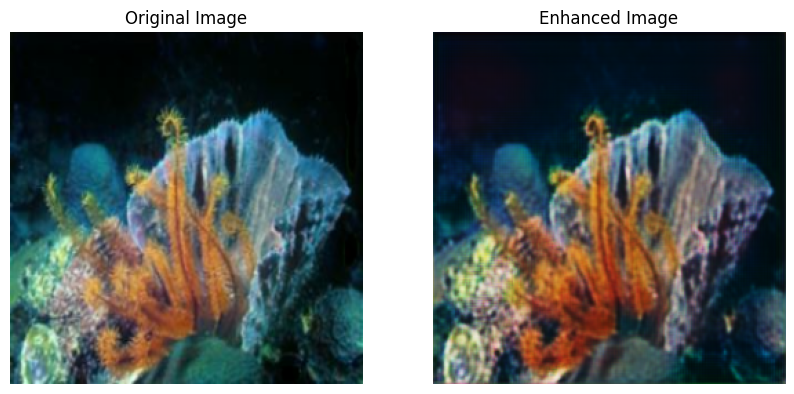

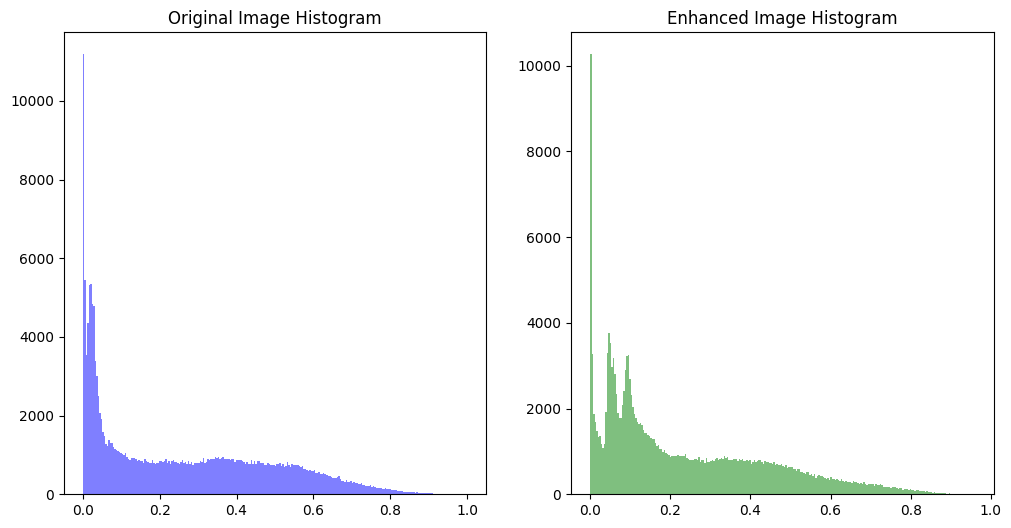

1/1 [==============================] - 0s 21ms/step


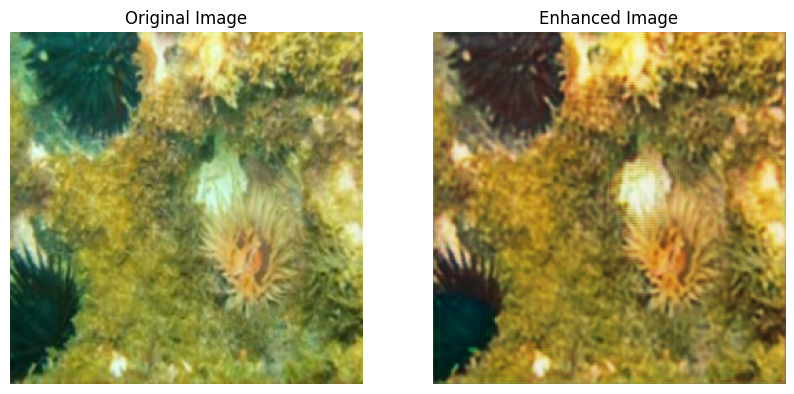

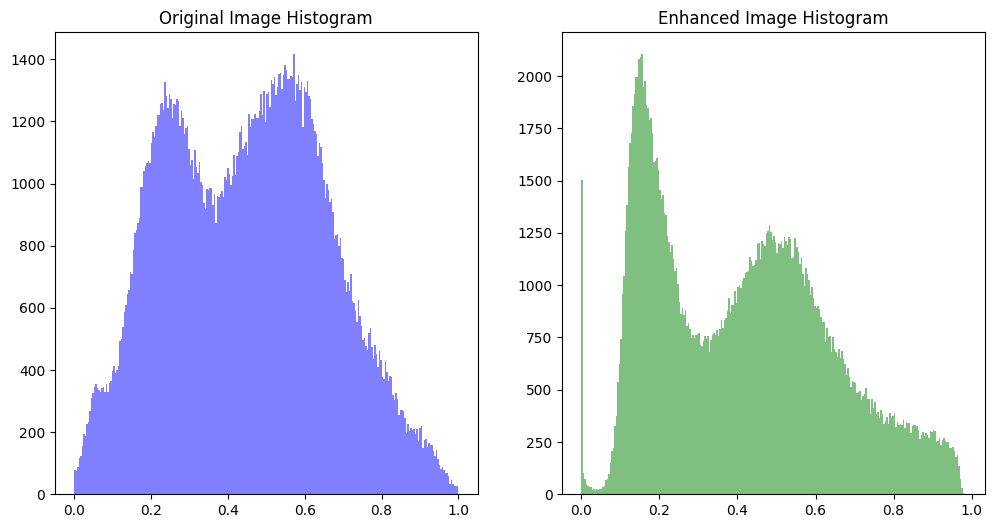

1/1 [==============================] - 0s 25ms/step


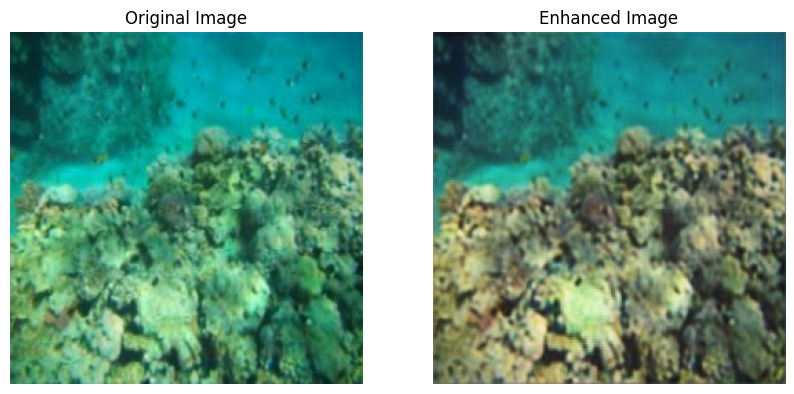

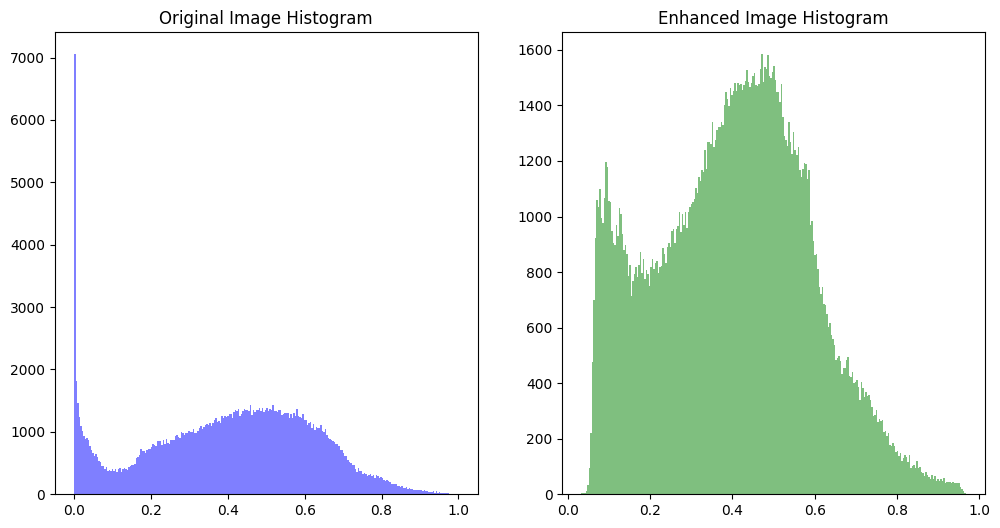

Average SSIM: 0.8763128519058228
Average PSNR: 20.72137561491719
Average MSE: 0.008858783209512163
Average VIFP: 1.0617180949033735


In [ ]:
# Function to evaluate metrics for a batch of images
def evaluate_batch_metrics(image_paths):
    ssim_values, psnr_values, mse_values, vifp_values = [], [], [], []

    for path in image_paths:
        original_image = tf.io.read_file(path)
        original_image = tf.image.decode_jpeg(original_image)
        original_image = tf.image.convert_image_dtype(original_image, tf.float32)
        original_image = preprocess_image(original_image)
        original_image = (original_image + 1) / 2  # Scale to [0, 1]
        original_image = original_image.numpy()

        enhanced_image = enhance_image(path)
        ssim_value, psnr_value, mse_value, vifp_value = calculate_metrics(original_image, enhanced_image)
        ssim_values.append(ssim_value)
        psnr_values.append(psnr_value)
        mse_values.append(mse_value)
        vifp_values.append(vifp_value)

        # Plot original and enhanced images
        plot_images(path, enhanced_image)

        # Plot histograms
        plot_histograms(path, enhanced_image)

    avg_ssim = np.mean(ssim_values)
    avg_psnr = np.mean(psnr_values)
    avg_mse = np.mean(mse_values)
    avg_vifp = np.mean(vifp_values)

    print(f"Average SSIM: {avg_ssim}")
    print(f"Average PSNR: {avg_psnr}")
    print(f"Average MSE: {avg_mse}")
    print(f"Average VIFP: {avg_vifp}")

# Example usage
sample_image_paths = [os.path.join('/content/dataset/dataset2/trainA', file) for file in os.listdir('/content/dataset/dataset2/trainA')[:10]]  # Sample a few images
evaluate_batch_metrics(sample_image_paths)